# Tutorial 06 - Pupil Diameter By Fixation On Surface
In this tutorial we will look at how to calculate the mean pupil diameter for each fixation on a given surface.
We will follow these steps:
1. Define the necessary file paths
1. Load the data using `Pandas`.
1. Select required columns
1. Group fixations by id
1. Extract pupil data for each fixation
1. Calculate mean pupil diameter for based on the extracted pupil data

Please check [Pupil Player](https://docs.pupil-labs.com/#pupil-player) docs to see how to export data. 
This Notebook is accompanied by an example [recording](https://drive.google.com/open?id=119Xxe1eYEgmXQTUK1RyytrBKly_vU6dQ) that contains exported data. To re-execute the cells below, first download the recording and unpack it inside the `recordings` directory next to the notebook.

This tutorial expects the recording to be exported with [Pupil Player `v1.15`](https://github.com/pupil-labs/pupil/releases/tag/v1.15).

## 1 - Define the necessary file paths
Let's start by importing the necessary Python modules and defining the necessary file paths.

In [1]:
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", font_scale=1.2)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
surface_name = "example"

recording = pathlib.Path("recordings") / "06_fixation_pupil_diameter"
export_dir = recording / "exports" / "000"
surface_dir = export_dir / "surfaces"

pupil_positions_file = export_dir / "pupil_positions.csv"
fixations_on_surface_file = surface_dir / f"fixations_on_surface_{surface_name}.csv"

print("Necessary files:")
print(pupil_positions_file)
print(fixations_on_surface_file)

Necessary files:
recordings/06_fixation_pupil_diameter/exports/000/pupil_positions.csv
recordings/06_fixation_pupil_diameter/exports/000/surfaces/fixations_on_surface_example.csv


## 2 - Load the data using `Pandas`
In the next steps we use the [Pandas](https://pypi.org/project/pandas/) project to load and filter the data.

In [3]:
pupil_positions = pd.read_csv(pupil_positions_file)
fixations_on_surface = pd.read_csv(fixations_on_surface_file)

## 3 - Select required columns
We only need a subset of the loaded columns:
- `pupil_positions.csv`
    - `pupil_timestamp`: Used for temporal correlation with fixations
    - `diameter_3d`: Used for aggregation to diameter mean
    - `confidence`: Used to filter low confidence data
- `fixations_on_surface_<surface name>.csv`:
    - `fixation_id`: Used to group fixations by id (see the [v1.15 release notes](https://github.com/pupil-labs/pupil/releases/tag/v1.15) on the reason for duplicated entries)
    - `start_timestamp`: Used for temporal correlation with pupil positions
    - `duration`: In ms, used for temporal correlation with pupil positions
    - `on_surf`: Used to filter fixations that are not positioned on the selected surface

In [4]:
pupil_positions = pupil_positions[["pupil_timestamp", "diameter_3d", "confidence"]]
fixations_on_surface = fixations_on_surface[["fixation_id", "start_timestamp", "duration", "on_surf"]]

pupil_positions.info()
print()
fixations_on_surface.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 3 columns):
pupil_timestamp    4872 non-null float64
diameter_3d        4872 non-null float64
confidence         4872 non-null float64
dtypes: float64(3)
memory usage: 114.3 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 4 columns):
fixation_id        552 non-null int64
start_timestamp    552 non-null float64
duration           552 non-null float64
on_surf            552 non-null bool
dtypes: bool(1), float64(2), int64(1)
memory usage: 13.6 KB


## 4 - Data processing

1. Group fixations by id
1. Extract pupil data for each fixation
    1. Check if fixation was on surface
    1. Calculate start and end point of each fixation
    1. Select all pupil data that lies between start and end point of each fixation
    1. Remove low confidence data
1. Calculate mean pupil diameter for based on the extracted pupil data

In [5]:
MIN_CONFIDENCE = 0.8

results = []

for _, fixations in fixations_on_surface.groupby("fixation_id"):  # group fixations by id
    first_fixation = fixations.iloc[0]
    if not first_fixation.on_surf:
        continue  # skip fixation since it is not on the surface

    # calculate start and end point
    fixation_id = first_fixation.fixation_id
    fixation_start = first_fixation.start_timestamp
    fixation_end = fixation_start + first_fixation.duration / 1000  # duration is in ms
    
    # boolean masks to filter pupil positions
    mask_after_start = fixation_start <= pupil_positions.pupil_timestamp
    mask_before_end = pupil_positions.pupil_timestamp <= fixation_end
    mask_high_confidence = pupil_positions.confidence >= MIN_CONFIDENCE

    # Extract pupil data for each fixation
    pupil_positions_during_fixation = pupil_positions[mask_after_start & mask_before_end & mask_high_confidence]
    diameter_3d_during_fixation = pupil_positions_during_fixation.diameter_3d
    
    # Calculate mean pupil diameter for based on the extracted pupil data
    results.append([fixation_id, diameter_3d_during_fixation.mean()])

# Create new data frame from results
mean_diameter_3d_by_fixation = pd.DataFrame(results, columns=["fixation_id", "mean_pupil_diameter_3d"])

## 5 - Visualize results

Below we plot the mean diameter for each fixation.

Text(0,0.5,'mean diameter_3d [mm]')

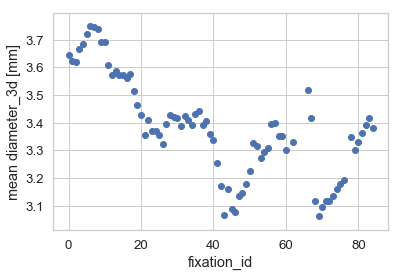

In [110]:
plt.scatter(mean_diameter_3d_by_fixation.fixation_id, mean_diameter_3d_by_fixation.mean_pupil_diameter_3d)
plt.xlabel("fixation_id")
plt.ylabel("mean diameter_3d [mm]")